# The Unscented Kalman Filter

After studying the Unscented transform in the previous notebook, now is time to apply it to the Kalman Filter for localization.

In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from celluloid import Camera
from IPython.display import HTML
import numpy as np
import os
import math
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)
from scipy.stats import multivariate_normal
from scipy import stats

%matplotlib inline

In [2]:
def normalize_angle(phi):
    # Normalize phi to be between -pi and pi
    while(phi>np.pi):
        phi -= 2*np.pi;


    while(phi<-np.pi):
        phi += 2*np.pi

    phiNorm = phi

    return phiNorm

# The unscented functions
These functions are explained in my previous notebook about the unscented transform, and thus here I will just directly write the code.

In [3]:
def compute_sigma_points( mu, sigma, lmbda, alpha, beta):
    n = mu.shape[0]
    # initialize sigma points
    sigma_points = np.zeros((n,2*n+1))+mu # matrix product this way is element-wise
    # compute square root matrix
    sqrm = np.sqrt((n+lmbda)*sigma)
    for i in range (1,n+1):
        sigma_points[:,i]+= sqrm[:,i-1]
    for i in range(n+1,2*n+1):
        sigma_points[:,i]-= sqrm[:,i-n-1]
  
    # compute the weights
    wc = np.ones((1,2*n+1))*lmbda/(n+lmbda)
    wc[0][1:] *= (1/(2*lmbda))
    wm = wc.copy()
    wc[0][0] += 1-alpha**2+beta

    return sigma_points,wm,wc

When recovering the Gaussian, we must be careful with averagin the angles. To average the angles ${\theta_1,...,\theta_N}$ given their weights  ${w_1,...,w_N}$ , we can first compute the weighted sum of the unit vectors of each rotation as

\begin{equation}
\overline{x} = \sum_{i=1}^N w_i cos(\theta_i) \text{,     } \overline{y} = \sum_{i=1}^N w_i sin(\theta_i)
\end{equation}

Then the average angle $\overline{\theta}$ is given by

\begin{equation}
\overline{\theta} = atan2(\overline{x} ,\overline{y})
\end{equation}


In [4]:
def recover_gaussian(sigmas,wm,wc):
    n = sigmas.shape[0]
    # initialize mean and covariance
    #mu = np.zeros((n,1))
    newsigma = np.zeros((n,n))

    # Compute mean and covar of the resulting distribution given the transformed
    # sigma points and corresponding weights
    mu = np.sum(sigmas*wm, axis = 1,keepdims = True)

    # The set of angles need to be averaged according to the given weights
    xavg = 0.0
    yavg = 0.0
    for i in range(2*n+1):
        xavg += wm[i] * math.cos(sigmas[2,i])
        yavg += wm[i] * math.sin(sigmas[2,i])
  
    mu[2] = normalize_angle(np.arctan2(xavg,yavg))

    # Compute sigma

    for i in range(2*n+1):
        dif = np.absolute(sigmas[:,i,np.newaxis]-mu)
        newsigma += wc[i]*np.matmul(dif,dif.T)


    # Add motion noise

    motionNoise = 0.1 
    R3 = np.identity(3)*motionNoise
    newsigma += R3

    return mu,newsigma

# Prediction step

|                 |  EKF  |   UKF  |
|:---------------:|:-----:|:------|
| **PREDICTION**  |   $\mu$ = $g(u_t,u_{t-1})$ from motion model |  $Y^{[i]}= g(X^{[i]})$  $\mu_t$ = $\sum_{i=0}^{2n}Y^{[i]}w^{[i]}_m$  |
|   **STEP**      | $\sum_t $=$ G_t\sum_{t-1}G^T_t+R_t$ | $\sum_t$ = $ \sum_{i=0}^{2n}(Y^{[i]}-\mu')(Y^{[i]}-\mu')^T+ Q$ propagation of motion |

The update is performed in the measurement space, so the transformation function $g$ that we're applying to the sigma points is the one that converts them to the measurement space.
Here, we are using again the odometry motion model for that.

Afterwards, we use the unscented transform to compute the mean and covariance of these points.

$R_t$ is added to the covariance in order to model the additional prediction noise uncertainty, which is assumed to be additive.



In [5]:
def prediction_step(mu,sigma,u):
    ''' Updates the belief of the robot pose according to the motion model.
    '''
    n = mu.shape[0]
    # Unscented parameters
    alpha = 0.9
    beta = 2
    kappa = 1
    lmbda = alpha**2*(n+kappa)-n

    # Compute the gaussian sigma points
    sigma_points, wm, wc = compute_sigma_points(mu,sigma,lmbda,alpha,beta)

    # Transform sigma points according to odometry motion model
    for i in range(sigma_points.shape[1]):
        sigma_points[:,i,np.newaxis] = sigma_points[:,i,np.newaxis] + np.array([[u['t'].iloc[0]*np.cos(u['r1'].iloc[0]+sigma_points[2,i])],
                                                                            [u['t'].iloc[0]*np.sin(u['r1'].iloc[0]+sigma_points[2,i])],
                                                                            [u['r1'].iloc[0]+u['r2'].iloc[0]]])
        sigma_points[2,i] = normalize_angle(sigma_points[2,i])

    # Recover mu and sigma

    newmu,newsigma = recover_gaussian(sigma_points,wm.flatten(),wc.flatten())

    return newmu,newsigma

# Correction step

We will compute a new set of sigma points from the gaussian we predicten in the previous step. This way, the sigma point set $\overline{X}_t$ captures the uncertainty after the prediction step.

Each landmark measurement (in this case, in form of range and bearing) is incorporated to the state vector from the prediction, and subsequently, its uncertainties are added to the covariance matrix.

Then, a predicted observation, that is, the predicted landmark position, is computed for each sigma point:
\begin{equation}
\overline{Z_t} = h(\overline{X}_t)
\end{equation}

These resulting observations are used to compute the predicted observation $\overline{z}_t$ and its uncertainty $S_t$.


In [6]:
def correction_step(mu,sigma,z,env_map):
    ''' Updates the belief, i. e., mu and sigma after observing landmarks, and augments
    the env_map after observing landmarks.
    The sensor model measures range and bearing of landmark.
    Each observation z has an id of the landmark, range and bearing.
    The env_map contains al the landmarks observed so far y the order of observation.
    '''
    n = mu.shape[0]

    # Unscented parameters
    alpha = 0.9
    beta = 2
    kappa = 1
    lmbda = alpha**2*(n+kappa)-n

    # Number of measurements in this time step
    m = z.shape[0]

    # Construct the sensor noise matrix Q
    Q = 0.01*np.identity(2)

    for i,row in z.iterrows():
        # Get the id of the landmark corresponding to the i-th observation
        landmarkId = int(row['r1']) # r1 == ID here

        # If the landmark is obeserved for the first time:
        if not landmarkId in env_map: # look for values of id in env_map list
            env_map.append(landmarkId)
        
            # Append the measurement to the state vector (t->range, r2->bearing)  
            mu = np.concatenate((mu,np.array([[row['t']],[row['r2']]])), axis = 0)
            # Initialize its uncertainty and add it to sigma
            sigma = scipy.linalg.block_diag(sigma,Q)
            # Sample signa points for this new state vector
            sigma_points, wm, wc = compute_sigma_points(mu,sigma,lmbda,alpha,beta)
            for i in range(sigma_points.shape[1]):
                sigma_points[2,i] = normalize_angle(sigma_points[2,i]) # normalize angles
            # Compute the xy location of the landmark according to each sigma point
            ldX = sigma_points








        # Initialize its pose in mu based on the measurement and the current robot pose:
        a = float(row['t']*np.cos(row['r2']+mu[2]))
        b = float(row['t']*np.sin(row['r2']+mu[2]))
        mu[2*env_map+1 : 2*env_map+3] = mu[0:2] + np.array([[a], [b]])
       
        # Indicate in the observedLandmarks vector that this landmark has been observed
        observedLandmarks[0][landmarkId-1] = 1 

    return mu,sigma,env_map


## Auxiliar functions

Functions for reading data from the attached files

In [7]:
def read_data(filename,path):
    data = pd.read_csv(path + filename,delimiter = ' ',header=None, names = ['sensor','r1','t','r2']) # or id, range and bearing for sensor
    return (data)

def read_world(filename,path):
    landmarks = pd.read_csv(path+filename,delimiter = ' ',header=None, names = ['x','y'])
    return (np.asarray(landmarks))

Functions for plotting

In [8]:
def world_plot(landmarks, fig, ax):
    ''' Draw the world grid with the ground truth landmarks'''
    ax.set_xticks([x for x in range(-2,12)],minor=True )
    ax.set_yticks([y for y in range(-2,12)],minor=True)
    # Plot grid on minor axes in gray (width = 1)
    plt.grid(which='minor',ls='-',lw=1, color='white')
    # Plot grid on major axes in larger width
    plt.grid(which='major',ls='-',lw=2, color='white')
    # Draw the ground truth of the landmarks
    for i,l in enumerate(landmarks):
        ax.text(l[0], l[1], 'x', ha='center', va='center', color='black', fontsize=20)
        #if (observedLandmarks[0][i] == 1.0):
            # plot landmark ellipse
            #e = plot_conf_ellipse(mu[2*i+3:2*i+5],sigma[2*i+3:2*i+5,2*i+3:2*i+5], 0.6, 'blue')
            #ax.add_patch(e)

    return fig,ax

def robot_plot(mu,sigma,fig,ax):
    ''' takes fig with a world plot, draws a robot in it'''
    # Draw the robot
    ax.text(mu[0], mu[1], 'o', ha='center', va='center', color='black', fontsize=20)
    e = plot_conf_ellipse(mu[0:3],sigma[0:3,0:3], 0.6, 'red')
    print(e)
    ax.add_patch(e)
    return fig,ax

In [9]:
from scipy.stats.distributions import chi2
def plot_conf_ellipse(x,C,alpha,color):
    # Calculate unscaled half axes
    sxx = C[0,0] 
    syy = C[1,1] 
    sxy = C[0,1]

    # Remove imaginary parts in case of neg. definite C
    a = np.sqrt(0.5*(sxx+syy+np.sqrt((sxx-syy)**2+4*sxy**2))).real   # always greater
    b = np.sqrt(0.5*(sxx+syy-np.sqrt((sxx-syy)**2+4*sxy**2))).real   # always smaller

    
    # Scaling in order to reflect specified probability    
    a = a*np.sqrt(chi2.ppf(alpha, df=2))
    b = b*np.sqrt(chi2.ppf(alpha, df=2))
    
    # Calculate inclination (numerically stable)
    if math.isclose(sxx, syy, rel_tol=0.1): # this function launches a warning
        angle =  0.5*np.arctan(2*sxy/(sxx-syy)) if (sxx-syy) != 0 else 0
    elif (sxy==0):
        print(2)
        angle = 0
    elif (sxy>0):
        print(3)
        angle = np.pi/4
    elif (sxy<0):
        print(4)
        angle = -np.pi/4

    return Ellipse((x[0],x[1]), a, b, angle, edgecolor = color, facecolor = color, alpha = alpha)

NameError: name 'landmarks' is not defined

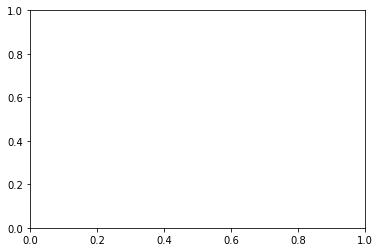

In [11]:
fig,ax =  plt.subplots()
fig,ax = world_plot(landmarks,fig,ax)
fig,ax = robot_plot(mu,sigma,fig,ax)

Add a column with the index of the timestep for each sensor read

In [12]:
data = read_data('ukf_sensor_data.dat',os.getcwd()+'/data/')
indexodometry = data[ (data['sensor'] == 'ODOMETRY')].index
timestepindex = []
timestep = 0
for i in range (0,data.shape[0]):
    if(timestep+1 < indexodometry.shape[0]):
        if (i < indexodometry[timestep+1]) :
            timestepindex.append(timestep)
        else:
            timestep +=1
            timestepindex.append(timestep)
    else:
        timestepindex.append(timestep)

data.insert(0, "timestep", timestepindex, True)
data

,timestep,sensor,r1,t,r2
0,0,ODOMETRY,0.100692,0.100073,0.000171
1,0,SENSOR,1.000000,1.896454,0.374032
2,0,SENSOR,2.000000,3.853678,1.519510
3,1,ODOMETRY,0.099366,0.099968,-0.000241
4,1,SENSOR,1.000000,1.839227,0.248026
...,...,...,...,...,...
1538,330,SENSOR,5.000000,4.951031,-1.512977
1539,330,SENSOR,6.000000,4.917189,-0.862938
1540,330,SENSOR,7.000000,-0.035066,0.975887
1541,330,SENSOR,8.000000,1.900675,3.144946


In [13]:
landmarks = read_world('ukf_world.dat',os.getcwd()+'/data/')
landmarks

array([[ 2,  1],
       [ 0,  4],
       [ 2,  7],
       [ 9,  2],
       [10,  5],
       [ 9,  8],
       [ 5,  5],
       [ 5,  3],
       [ 5,  9]])

Initialize the belief

In [14]:
mu = np.zeros((3,1))
sigma = np.identity((3))*0.1

Execute the loop

In [15]:
def ukf_loop(mu, sigma,sensor_data, env_map):
    for t in range (0, 10):#timestepindex[-1]):
        # Perform the prediction step of the UKF
        mu, sigma = prediction_step(mu,sigma,sensor_data.loc[(sensor_data['timestep'] == t) & (sensor_data['sensor'] == 'ODOMETRY')])
        mu,sigma = correction_step(mu,sigma,data.loc[(data['timestep'] == t) & (data['sensor'] == 'SENSOR')],env_map)
  
    return mu,sigma

In [16]:
mu = np.zeros((3,1))
sigma = np.identity((3))*0.001
env_map = []

mu,sigma = ukf_loop(mu,sigma,data, env_map)

TypeError: can only concatenate list (not "int") to list